In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification import marginal_counts
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [3]:
sim = Aer.get_backend('qasm_simulator')

# Build noise model from backend properties
backend = provider.get_backend('ibmq_quito')

# Get noise model from real device 'ibmq_quito'
noise_model_device = NoiseModel.from_backend(backend)
# print(noise_model_device)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model_device.basis_gates

T1 = backend.properties().t1(0) * 1e9
T2 = backend.properties().t2(0) * 1e9
duration_x = backend.properties().gate_length("x", 0) * 1e9
duration_cx = backend.properties().gate_length("cx", {0, 1}) * 1e9
duration_meas = backend.properties().readout_length(0) * 1e9
duration_reset = duration_meas

print("T1: %.3f ns"%T1)
print("T2: %.3f ns"%T2)
print("duration_x: %.3f ns"%duration_x)
print("duration_cx: %.3f ns"%duration_cx)
print("duration_meas: %.3f ns"%duration_meas)
print("duration_reset: %.3f ns"%duration_reset)


T1: 103241.527 ns
T2: 157828.542 ns
duration_x: 35.556 ns
duration_cx: 234.667 ns
duration_meas: 5351.111 ns
duration_reset: 5351.111 ns


In [10]:
# build a customised noise model
def build_thermal_noise_model(n_qubits, reset, meas, x, cx):
    noise_model = NoiseModel()
    
    # T1 and T2 values for all qubits (following normal distribution)
    T1s = np.random.normal(T1, 10e3, n_qubits)
    T2s = np.random.normal(T2, 10e3, n_qubits)

    # Ensure T2 <= 2T1
    T2s = np.array([min(T2s[i], 2 * T1s[i]) for i in range(n_qubits)])

    errors_reset = [thermal_relaxation_error(t1, t2, duration_reset)
                  for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, duration_meas)
                  for t1, t2 in zip(T1s, T2s)]
    errors_x  = [thermal_relaxation_error(t1, t2, duration_x)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, duration_cx).expand(
                 thermal_relaxation_error(t1b, t2b, duration_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]
        
    for i in range(n_qubits):
        if reset:
            # add thermal reset noise to measurements
            noise_model.add_quantum_error(errors_reset[i], "reset", [i])
        if meas:
            # add thermal measurement noise to measurements
            noise_model.add_quantum_error(errors_measure[i], "measure", [i])
        if x:
            # add thermal gate noise to X-gates
            noise_model.add_quantum_error(errors_x[i], "x", [i])
        if cx:
            # add thermal gate noise to CX-gates
            for j in range(n_qubits):
                noise_model.add_quantum_error(errors_cx[i][j], "cx", [i, j])
    
    return noise_model


In [5]:
def simulate(circuit, noise_model=None):
    if noise_model == None:
        # Perform a noiseless simulation
        result = execute(circuit, backend=sim, shots=10000).result()
        return result.get_counts()
    
    # Perform a noisy simulation with an indicated noise model
    result_noisy = execute(circuit, backend=sim, shots=10000, noise_model=noise_model).result()
    return result_noisy.get_counts()
    

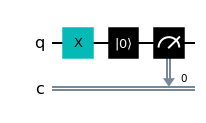

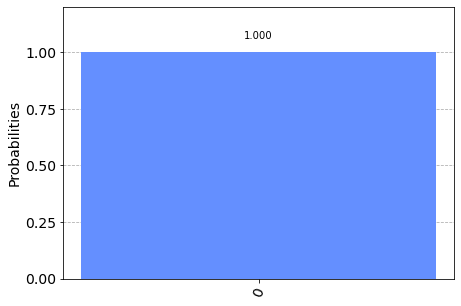

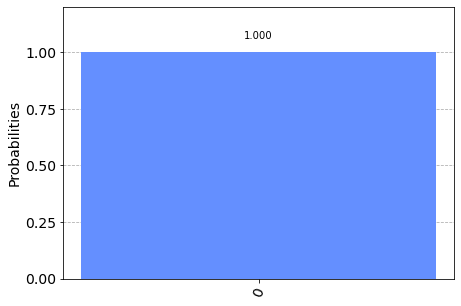

In [9]:
# Proof of the zero value for reset thermal noise
# circ2 = QuantumCircuit(1, 1)
# circ2.x(0)
# circ2.reset(0)
# circ2.measure(0, 0)
# display(circ2.draw('mpl'))

# noise_model = build_noise_model(0, 0, 0.6, False, 1)
# perfect_counts = simulate(circ2)
# display(plot_histogram(perfect_counts))
# total_counts = simulate(circ2, noise_model)
# display(plot_histogram(total_counts))

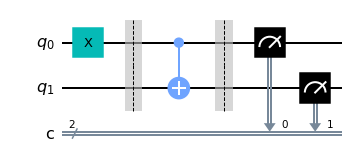

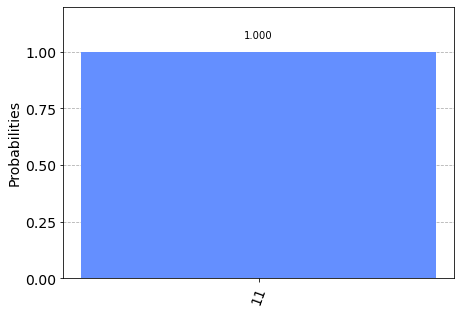

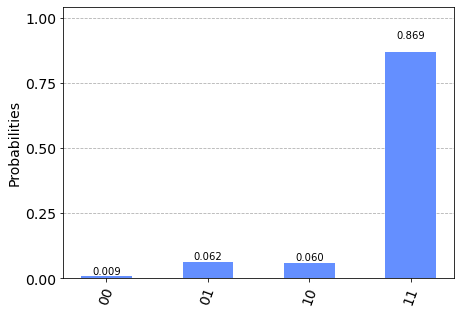

[0, 145, 1, 5]


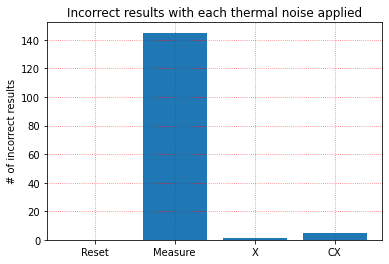

In [22]:
# XOR Gate
xor_circ = QuantumCircuit(2, 2)
xor_circ.x(0)
xor_circ.barrier()
xor_circ.cx(0, 1)
xor_circ.barrier()
# the reset error will be applied just before the measurement
# xor_circ.reset(0)
xor_circ.measure([0, 1], [0, 1])
display(xor_circ.draw('mpl'))

noise_model = build_thermal_noise_model(2, 1, 1, 1, 1)
noise_model2 = build_thermal_noise_model(2, 1, 0, 0, 0)
noise_model3 = build_thermal_noise_model(2, 0, 1, 0, 0)
noise_model4 = build_thermal_noise_model(2, 0, 0, 1, 0)
noise_model5 = build_thermal_noise_model(2, 0, 0, 0, 1)

# Simulations without any noise and with all thermal relaxation noises
perfect_counts = simulate(xor_circ)
display(plot_histogram(perfect_counts))
total_counts = simulate(xor_circ, noise_model)
display(plot_histogram(total_counts))

# Simulation with each single type of thermal relaxation noises
reset_counts = simulate(xor_circ, noise_model2)
measure_counts = simulate(xor_circ, noise_model3)
x_counts = simulate(xor_circ, noise_model4)
cx_counts = simulate(xor_circ, noise_model5)

labels = ['Reset', 'Measure', 'X', 'CX']
error_counts = [1000 - reset_counts['11'], 1000 - measure_counts['11'], 1000 - x_counts['11'], 1000 - cx_counts['11']]
print(error_counts)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.xticks(x, labels)
plt.bar(x, error_counts)
plt.title('Incorrect results with each thermal noise applied')
plt.ylabel('# of incorrect results')
plt.grid(True, linestyle=':', color='r', alpha=0.6)
plt.show()

# # Run the circuit on a real quantum computer
# job = execute(xor_circ, backend=backend)
# job_monitor(job)
# result2 = job.result()
# counts2 = result2.get_counts()
# display(plot_histogram(counts2))

# # Perform a noisy simulation (device)
# result_noisy2 = execute(xor_circ, backend=sim,
#                  coupling_map=coupling_map,
#                  basis_gates=basis_gates,
#                  noise_model=noise_model_device).result()
# counts_noisy2 = result_noisy2.get_counts()
# display(plot_histogram(counts_noisy2))


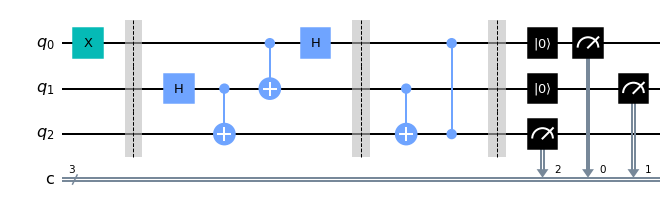

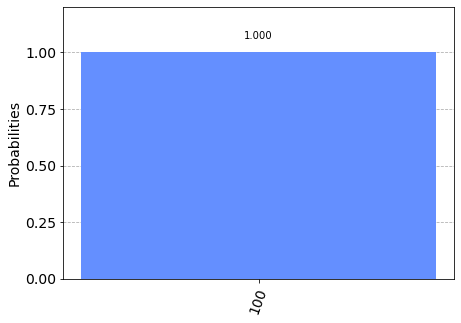

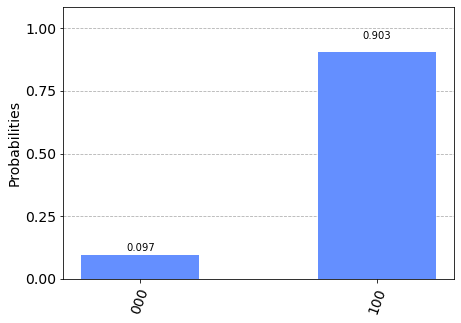

[0, 67, 1, 10]


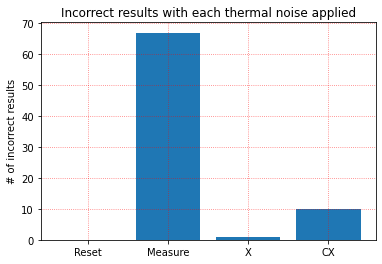

In [23]:
# Quantum Teleportation
tele_circ = QuantumCircuit(3, 3)
tele_circ.x(0)
tele_circ.barrier()

# Create an entangled state
tele_circ.h(1)
tele_circ.cx(1, 2)

tele_circ.cx(0, 1)
tele_circ.h(0)
tele_circ.barrier()

tele_circ.cx(1, 2) # if q1 is 1, apply X (01)
tele_circ.cz(0, 2) # if q0 is 1, apply Z (10)
# if q0 and q1 are both 1, apply ZX (11)

tele_circ.barrier()
tele_circ.reset([0, 1])
tele_circ.measure([0, 1, 2], [0, 1, 2])
# tele_circ.measure(2, 2)
display(tele_circ.draw(output='mpl'))

noise_model = build_thermal_noise_model(3, 1, 1, 1, 1)
noise_model2 = build_thermal_noise_model(3, 1, 0, 0, 0)
noise_model3 = build_thermal_noise_model(3, 0, 1, 0, 0)
noise_model4 = build_thermal_noise_model(3, 0, 0, 1, 0)
noise_model5 = build_thermal_noise_model(3, 0, 0, 0, 1)

# Simulations without any noise and with all thermal relaxation noises
perfect_counts = simulate(tele_circ)
display(plot_histogram(perfect_counts))
total_counts = simulate(tele_circ, noise_model)
display(plot_histogram(total_counts))

# Simulation with each single type of thermal relaxation noises
reset_counts = simulate(tele_circ, noise_model2)
measure_counts = simulate(tele_circ, noise_model3)
x_counts = simulate(tele_circ, noise_model4)
cx_counts = simulate(tele_circ, noise_model5)

labels = ['Reset', 'Measure', 'X', 'CX']
error_counts = [1000 - reset_counts['100'], 1000 - measure_counts['100'], 1000 - x_counts['100'], 1000 - cx_counts['100']]
print(error_counts)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.xticks(x, labels)
plt.bar(x, error_counts)
plt.title('Incorrect results with each thermal noise applied')
plt.ylabel('# of incorrect results')
plt.grid(True, linestyle=':', color='r', alpha=0.6)
plt.show()

# # Run the circuit on a real quantum computer
# job = execute(tele_circ, backend=backend)
# job_monitor(job)
# result2 = job.result()
# counts2 = result2.get_counts()
# display(plot_histogram(counts2))

# # Perform a noisy simulation (device)
# result_noisy2 = execute(tele_circ, backend=sim,
#                  coupling_map=coupling_map,
#                  basis_gates=basis_gates,
#                  noise_model=noise_model_device).result()
# counts_noisy2 = result_noisy2.get_counts()
# display(plot_histogram(counts_noisy2))


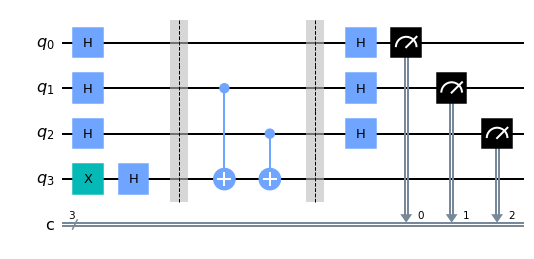

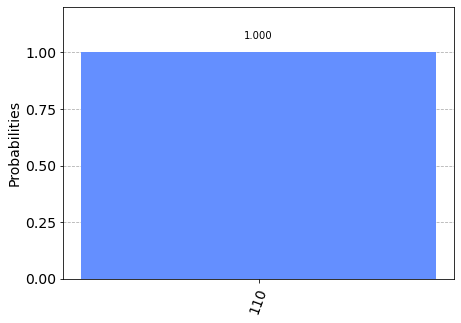

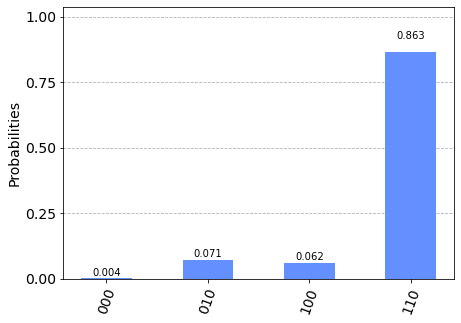

[0, 116, 0, 5]


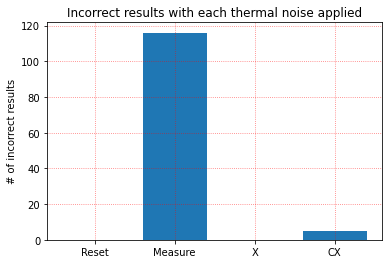

In [32]:
# Bernstein-Vazirani
secretnumber = '110'

bv_circ = QuantumCircuit(len(secretnumber)+1, len(secretnumber))

bv_circ.h(range(len(secretnumber)))
bv_circ.x(len(secretnumber))
bv_circ.h(len(secretnumber))
bv_circ.barrier()

# all 1s from last bit to first bit
for index, digit in enumerate((reversed(secretnumber))):
    if digit is '1':
        bv_circ.cx(index, len(secretnumber))
bv_circ.barrier()

bv_circ.h(range(len(secretnumber)))

# bv_circ.reset(0)
bv_circ.measure(range(len(secretnumber)), range(len(secretnumber)))
display(bv_circ.draw(output='mpl'))

noise_model = build_thermal_noise_model(len(secretnumber)+1, 1, 1, 1, 1)
noise_model2 = build_thermal_noise_model(len(secretnumber)+1, 1, 0, 0, 0)
noise_model3 = build_thermal_noise_model(len(secretnumber)+1, 0, 1, 0, 0)
noise_model4 = build_thermal_noise_model(len(secretnumber)+1, 0, 0, 1, 0)
noise_model5 = build_thermal_noise_model(len(secretnumber)+1, 0, 0, 0, 1)

# Simulations without any noise and with all thermal relaxation noises
perfect_counts = simulate(bv_circ)
display(plot_histogram(perfect_counts))
total_counts = simulate(bv_circ, noise_model)
display(plot_histogram(total_counts))

# Simulation with each single type of thermal relaxation noises
reset_counts = simulate(bv_circ, noise_model2)
measure_counts = simulate(bv_circ, noise_model3)
x_counts = simulate(bv_circ, noise_model4)
cx_counts = simulate(bv_circ, noise_model5)

labels = ['Reset', 'Measure', 'X', 'CX']
error_counts = [1000 - reset_counts['110'], 1000 - measure_counts['110'], 1000 - x_counts['110'], 1000 - cx_counts['110']]
print(error_counts)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.xticks(x, labels)
plt.bar(x, error_counts)
plt.title('Incorrect results with each thermal noise applied')
plt.ylabel('# of incorrect results')
plt.grid(True, linestyle=':', color='r', alpha=0.6)
plt.show()

# # Run the circuit on a real quantum computer
# job = execute(bv_circ, backend=backend)
# job_monitor(job)
# result2 = job.result()
# counts2 = result2.get_counts()
# display(plot_histogram(counts2))

# # Perform a noisy simulation (device)
# result_noisy2 = execute(bv_circ, backend=sim,
#                  coupling_map=coupling_map,
#                  basis_gates=basis_gates,
#                  noise_model=noise_model_device).result()
# counts_noisy2 = result_noisy2.get_counts()
# display(plot_histogram(counts_noisy2))


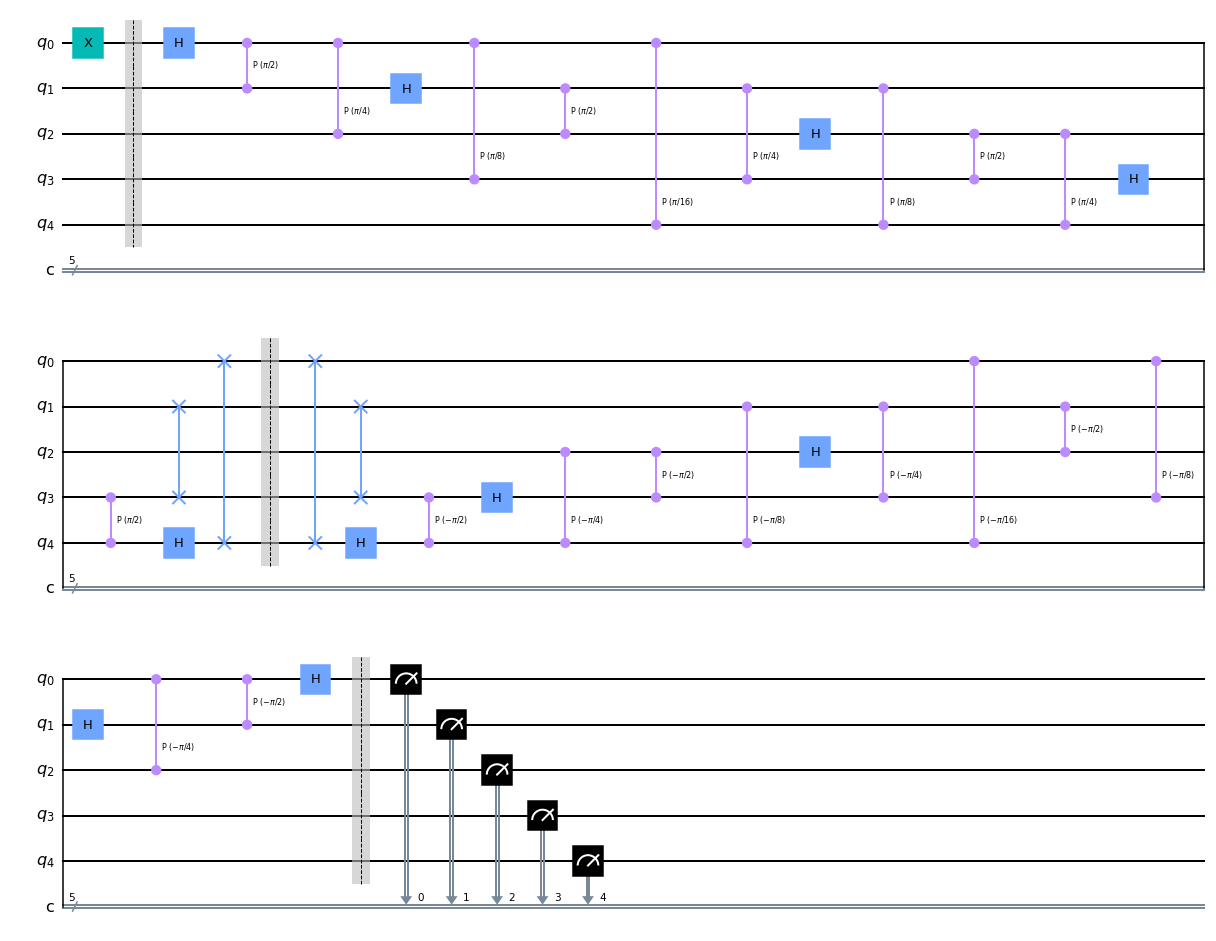

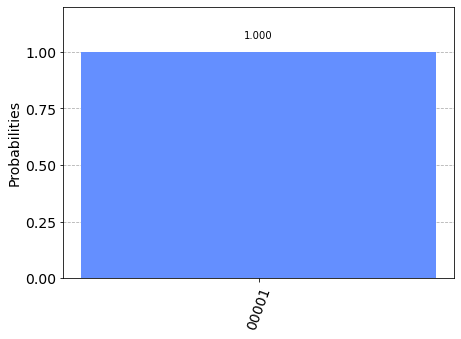

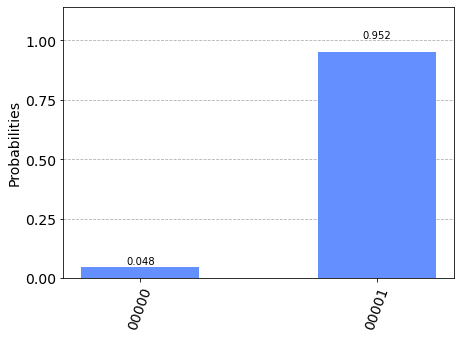

[0, 511, 4, 0]


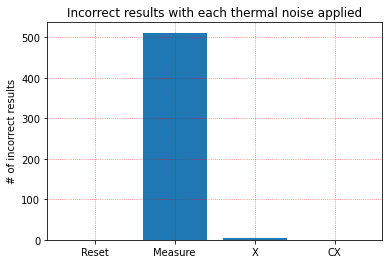

In [18]:
pi = np.pi
circ = QuantumCircuit(5,5)

circ.x(0)
circ.barrier()
circ.h(0)
circ.cp(pi/2,0,1)
circ.cp(pi/4,0,2)

circ.h(1)
circ.cp(pi/8,0,3)
circ.cp(pi/2,1,2)
circ.cp(pi/16,0,4)
circ.cp(pi/4,1,3)

circ.h(2)
circ.cp(pi/8,1,4)
circ.cp(pi/2,2,3)
circ.cp(pi/4,2,4)

circ.h(3)
circ.cp(pi/2,3,4)

circ.h(4)

circ.swap(1,3)
circ.swap(0,4)

circ.barrier()

circ.swap(0,4)
circ.swap(1,3)

circ.h(4)
circ.cp(-pi/2,3,4)
circ.h(3)
circ.cp(-pi/4,2,4)
circ.cp(-pi/2,2,3)
circ.cp(-pi/8,1,4)
circ.h(2)
circ.cp(-pi/4,1,3)
circ.cp(-pi/16,0,4)
circ.cp(-pi/2,1,2)
circ.cp(-pi/8,0,3)
circ.h(1)

circ.cp(-pi/4,0,2)

circ.cp(-pi/2,0,1)


circ.h(0)

circ.barrier()

circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)
circ.measure(3,3)
circ.measure(4,4)
display(circ.draw('mpl'))

noise_model = build_thermal_noise_model(2, 1, 1, 1, 1)
noise_model2 = build_thermal_noise_model(2, 1, 0, 0, 0)
noise_model3 = build_thermal_noise_model(2, 0, 1, 0, 0)
noise_model4 = build_thermal_noise_model(2, 0, 0, 1, 0)
noise_model5 = build_thermal_noise_model(2, 0, 0, 0, 1)

# Simulations without any noise and with all thermal relaxation noises
perfect_counts = simulate(circ)
display(plot_histogram(perfect_counts))
total_counts = simulate(circ, noise_model)
display(plot_histogram(total_counts))

# Simulation with each single type of thermal relaxation noises
reset_counts = simulate(circ, noise_model2)
measure_counts = simulate(circ, noise_model3)
x_counts = simulate(circ, noise_model4)
cx_counts = simulate(circ, noise_model5)

labels = ['Reset', 'Measure', 'X', 'CX']
error_counts = [10000 - reset_counts['00001'], 10000 - measure_counts['00001'], 10000 - x_counts['00001'], 10000 - cx_counts['00001']]
print(error_counts)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.xticks(x, labels)
plt.bar(x, error_counts)
plt.title('Incorrect results with each thermal noise applied')
plt.ylabel('# of incorrect results')
plt.grid(True, linestyle=':', color='r', alpha=0.6)
plt.show()